In [1]:
import torch
import math
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import signal
from torchaudio.functional import bandpass_biquad, lfilter
from pathlib import Path

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
class BiquadBandpass(nn.Module):
    def __init__(
        self,
        sample_rate: int,
        central_freq: float,
        Q: float = 0.707,
        const_skirt_gain: bool = False,
        trainable: bool = False,
    ):
        super().__init__()
        central_freq = torch.as_tensor(central_freq)
        Q = torch.as_tensor(Q)

        w0 = 2 * math.pi * central_freq / sample_rate
        alpha = torch.sin(w0) / 2 / Q

        temp = torch.sin(w0) / 2 if const_skirt_gain else alpha
        self.b0 = torch.as_tensor(temp).view(1)
        self.b1 = torch.as_tensor(0.0).view(1)
        self.b2 = torch.as_tensor(-temp).view(1)
        self.a0 = torch.as_tensor(1 + alpha).view(1)
        self.a1 = torch.as_tensor(-2 * torch.cos(w0)).view(1)
        self.a2 = torch.as_tensor(1 - alpha).view(1)
        
        if trainable:
            self.b0 = nn.Parameter(self.b0, requires_grad=True)
            self.b1 = nn.Parameter(self.b1, requires_grad=True)
            self.b2 = nn.Parameter(self.b2, requires_grad=True)
            self.a0 = nn.Parameter(self.a0, requires_grad=True)
            self.a1 = nn.Parameter(self.a1, requires_grad=True)
            self.a2 = nn.Parameter(self.a2, requires_grad=True)
            self.register_parameter('b0', self.b0)
            self.register_parameter('b1', self.b1)
            self.register_parameter('b2', self.b2)
            self.register_parameter('a0', self.a0)
            self.register_parameter('a1', self.a1)
            self.register_parameter('a2', self.a2)
            
    def forward(self, waveform):
        output_waveform = lfilter(
            waveform,
            torch.cat([self.a0, self.a1, self.a2]),
            torch.cat([self.b0, self.b1, self.b2]),
        )

        return output_waveform

In [17]:
def load_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
    # return waves / np.max(waves, axis=1).reshape(3, 1)
    return waves / np.max(np.abs(waves))


def apply_bandpass(x, lf=25, hf=500, order=4, sr=2048):
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization

In [18]:
highcut = 500
lowcut = 35

central_freq = (highcut + lowcut) / 2
q_value = (highcut - lowcut) / (highcut + lowcut)

In [19]:
data = torch.from_numpy(load_file("098a464da9")).float()
data.shape

torch.Size([3, 4096])

In [21]:
data[0].max(), data[0].min(), data[0].mean()

(tensor(0.4660), tensor(-0.5062), tensor(-0.0007))

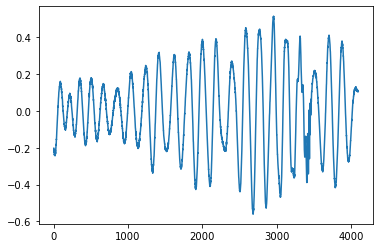

In [6]:
plt.plot(data[0]);

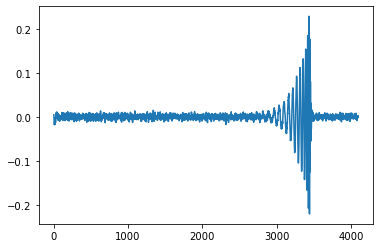

In [7]:
bp0 = apply_bandpass(data, lowcut, highcut, 4, 2048)
plt.plot(bp0[0]);

In [8]:
bp1 = bandpass_biquad(data, 2048, central_freq, q_value)
bp1.shape

torch.Size([3, 4096])

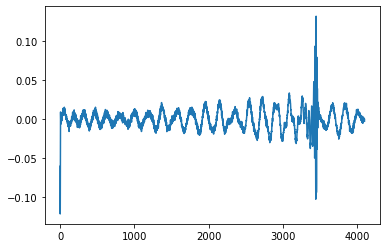

In [9]:
plt.plot(bp1[0]);

In [10]:
bandpass = BiquadBandpass(2048, central_freq, q_value, trainable=True)
bp2 = bandpass(data)
bp2.shape

torch.Size([3, 4096])

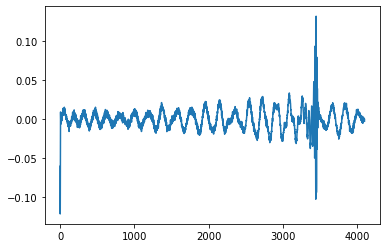

In [11]:
plt.plot(bp2[0].detach());

In [12]:
for p in bandpass.parameters():
    print(p)

Parameter containing:
tensor([0.4209], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([-0.4209], requires_grad=True)
Parameter containing:
tensor([1.4209], requires_grad=True)
Parameter containing:
tensor([-1.3634], requires_grad=True)
Parameter containing:
tensor([0.5791], requires_grad=True)
